# `photoeccentric` Tutorial

In this tutorial, I will create a simulated transit based on a Kepler planet and demonstrate how to use `photoeccentric` to recover the planet's eccentricity using the photoeccentric effect [(Dawson & Johnson 2012)](https://arxiv.org/pdf/1203.5537.pdf).

The code I'm using to implement the photoeccentric effect is compiled into a package called `photoeccentric`, and can be viewed/downloaded here: https://github.com/ssagear/photoeccentric

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import os
import pickle
import scipy
import random

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares

# Using juliet & corner to find and plot (e, w) distribution
import juliet
import corner

# Using dynesty to do the same with nested sampling
import dynesty

# And importing `photoeccentric`
import photoeccentric as ph

%load_ext autoreload
%autoreload 2

# pandas display option
pd.set_option('display.float_format', lambda x: '%.5f' % x)

spectplanets = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/HiPerGator/HPG_Replica/datafiles/spectplanets.csv')
muirhead_comb = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/HiPerGator/HPG_Replica/datafiles/muirhead_comb.csv')
muirheadKOIs = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/HiPerGator/HPG_Replica/datafiles/MuirheadKOIs.csv')
lcpath = '/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/HiPerGator/HPG_Replica/sample_lcs'

plt.rcParams['figure.figsize'] = [20, 10]

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload







I'll define the conversions between solar mass -> kg and solar radius -> meters for convenience.

In [29]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## The Sample

I'm using the sample of "cool KOIs" from [Muirhead et al. 2013](https://iopscience.iop.org/article/10.1088/0067-0049/213/1/5), and their properites from spectroscopy published here.

I'm reading in several .csv files containing data for this sample. The data includes spectroscopy data from Muirhead et al. (2013), stellar and planet parameters from the Kepler archive, and distances/luminosities from Gaia. 

In [30]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_incmissing.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = pd.read_csv('datafiles/database/spectplanets.csv')

# Kepler-Gaia Data
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = pd.read_csv("datafiles/database/muirhead_gaia.csv")

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.read_csv('datafiles/database/muirhead_comb.csv')

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = pd.read_csv('datafiles/database/muirhead_comb_lums.csv')

In [31]:
# star = ph.KeplerStar(int(np.floor(float(nkoi))))
# star.get_stellar_params(isodf)
# koi = ph.KOI(nkoi, int(np.floor(float(nkoi))), isodf)
# koi.get_KIC(muirhead_comb)
# koi.planet_params_from_archive(spectplanets)
# koi.calc_a(koi.mstar, koi.rstar)

# nbuffer, nlinfit = 7, 6

# KICs = np.sort(np.unique(np.array(muirhead_comb['KIC'])))
# KOIs = np.sort(np.unique(np.array(muirhead_comb['KOI'])))

# files = ph.get_lc_files(koi.KIC, KICs, lcpath)

# koi.get_stitched_lcs(files)
# koi.get_midpoints()
# koi.remove_oot_data(nbuffer, nlinfit)

# time, flux, fluxerr = koi.time_intransit, koi.flux_intransit, koi.fluxerr_intransit

# Defining a "test planet"


### I'm going to pick a planet from our sample to test how well `photoeccentric` works. Here, I'm picking KOI 818.01 (Kepler-691 b), a super-Earth orbiting an M dwarf.
[Exoplanet Catalog Entry](https://exoplanets.nasa.gov/exoplanet-catalog/4987/kepler-691-b/)

It has an orbital period of about 8 days.

First, I'll use the spectroscopy data from Muirhead et al. 2013 and Gaia luminosities to constrain the mass and radius of the host star beyond the constraint published in the Exoplanet Archive. I'll do this by matching these data with stellar isochrones [MESA](https://iopscience.iop.org/article/10.3847/0004-637X/823/2/102) and using the masses/radii from the matching isochrones to constrian the stellar density.

In [32]:
nkoi = 818.01

I'll read in a file with the  MESA stellar isochrones for low-mass stars. I'll use `ph.fit_isochrone_lum()` to find the subset of stellar isochrones that are consistent with a certain stellar parameters form Kepler-691 (Teff, Mstar, Rstar, and Gaia luminosity). 

In [33]:
# # Read in MESA isochrones
isochrones = pd.read_csv('datafiles/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')


Using `ph.fit_isochrone_lum()` to match isochrones to stellar data:

In [34]:
koi818 = muirhead_comb.loc[muirhead_comb['KOI'] == '818']

In [35]:
iso_lums = ph.fit_isochrone_lum(koi818, isochrones)

100%|██████████| 738479/738479 [00:06<00:00, 111202.56it/s]

Number of fit isochrones:  84


In [36]:
# Write to csv, then read back in (prevents notebook from lagging)
iso_lums.to_csv("tutorial/iso_lums_" + str(nkoi) + ".csv")

In [37]:
isodf = pd.read_csv("tutorial/iso_lums_" + str(nkoi) + ".csv")

Define a KeplerStar object, and use  ph.get_stellar_params and the fit isochrones to get the stellar parameters.

In [38]:
SKOI = int(np.floor(float(nkoi)))
print('System KOI', SKOI)

star = ph.KeplerStar(SKOI)
star.get_stellar_params(isodf)

System KOI 818


In [39]:
print('Stellar Mass (Msol): ', star.mstar)
print('Stellar Radius (Rsol): ', star.rstar)
print('Average Stellar Density (kg m^-3): ', star.rho_star)

Stellar Mass (Msol):  0.5691952380952375
Stellar Radius (Rsol):  0.5488321428571431
Average Stellar Density (kg m^-3):  4869.801369605661


Define a KOI object.

In [40]:
koi = ph.KOI(nkoi, SKOI, isodf)
koi.get_KIC(muirhead_comb)

print('KIC', koi.KIC)

KIC 4913852


# Creating a fake light curve based on a real planet

I'm pulling the planet parameters of Kepler-691 b from the exoplanet archive using `ph.planet_params_from_archive()`. This will give me the published period, Rp/Rs, and inclination constraints of this planet.

I'm calculating a/Rs using `ph.calc_a()`, instead of using the a/Rs constraint from the Exoplanet Archive. The reason is because a/Rs must be consistent with the density calculated above from spectroscopy/Gaia for the photoeccentric effect to work correctly, and the published a/Rs is often inconsistent. a/Rs depends on the orbital period, Mstar, and Rstar.


Let's force the inclination to be 90 deg for this example.

In [41]:
koi.planet_params_from_archive(spectplanets)
koi.calc_a(koi.mstar, koi.rstar)

print('Stellar mass (Msun): ', koi.mstar, 'Stellar radius (Rsun): ', koi.rstar)
print('Period (Days): ', koi.period, 'Rp/Rs: ', koi.rprs)
print('a/Rs: ', koi.a_rs)

koi.i = 90.
print('i (deg): ', koi.i)

Stellar mass (Msun):  0.5691952380952375 Stellar radius (Rsun):  0.5488321428571431
Period (Days):  8.11437482 Rp/Rs:  0.037204
a/Rs:  25.63672846518325
i (deg):  90.0


Now, I'll create a fake transit using `batman`.
I'm creating a model with the period, Rp/Rs, a/Rs, and inclination specified by the Kepler catalog entry and the density constraints.

I'll create the transit model with an $e$ and $w$ of my choice. This will allow me to test whether `photoeccentric` accurately recovers the $(e,w)$ combination I have input. I'll start with $e = 0.0$ and $w = 90.0$ degrees.

## $e = 0.0$, $\omega = 90.0$

I
define a cadence length (~30  minutes, in days) that matches the Kepler long-cadence integration time, so I can create a fake light curve that integrates over the same time as real Kepler light curves.

I want to replicate the real Kepler light curve as closely as possible. So I am taking these parameters fromm the light curves

In [42]:
# Define the working directory
direct = 'tutorial/' + str(nkoi) + '/e_0.0_w_90.0/'

First, reading in the light curves that I have saved for this planet.

In [43]:
KICs = np.sort(np.unique(np.array(muirhead_comb['KIC'])))
KOIs = np.sort(np.unique(np.array(muirhead_comb['KOI'])))

files = ph.get_lc_files(koi.KIC, KICs, lcpath)

In [44]:
# Stitching the light curves together, preserving the time stamps
koi.get_stitched_lcs(files)

# Getting the midpoint times
koi.get_midpoints()

In [45]:
starttime = koi.time[0]
endtime = koi.time[-1]

In [46]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(starttime, endtime, cadence)

In [47]:
# Define e and w, calculate flux from transit model
e = 0.0
w = 90.0

params = batman.TransitParams()       #object to store transit parameters
params.t0 = koi.epoch                        #time of inferior conjunction
params.per = koi.period                       #orbital period
params.rp = koi.rprs                       #planet radius (in units of stellar radii)
params.a = koi.a_rs                        #semi-major axis (in units of stellar radii)
params.inc = koi.i                      #orbital inclination (in degrees)
params.ecc = e                       #eccentricity
params.w = w                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = time
m = batman.TransitModel(params, t, supersample_factor = 29, exp_time = 0.0201389)

In [48]:
flux = m.light_curve(params)

Text(0.5, 1.0, 'Transit LC Model')

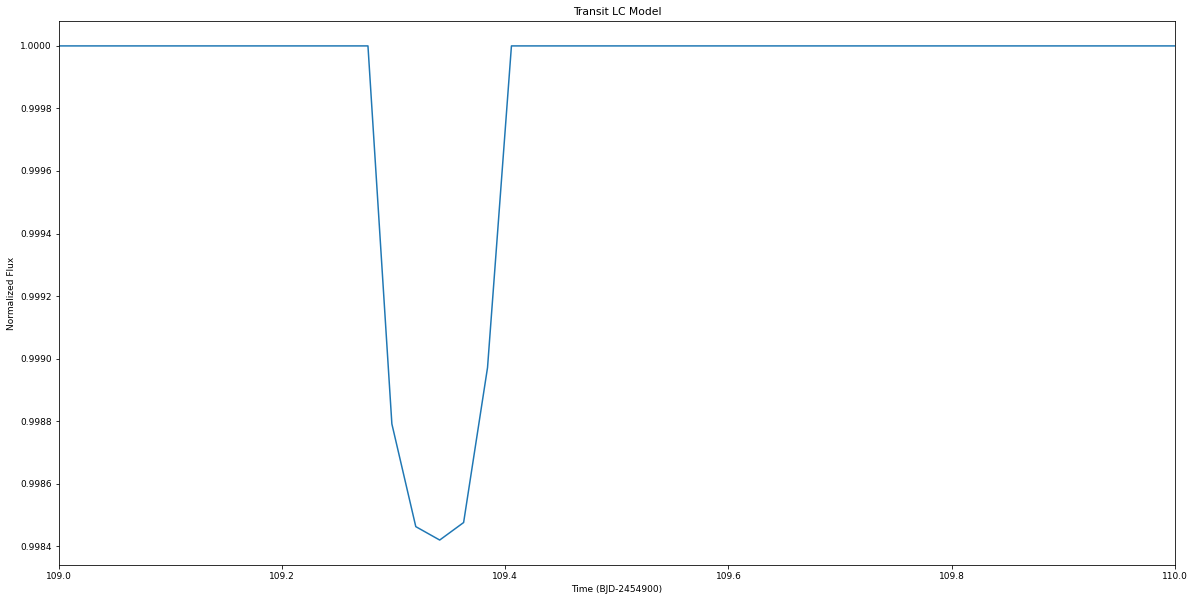

In [49]:
time = time
flux = flux

plt.plot(time-2454900, flux)
plt.xlim(109,110)
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Normalized Flux')
plt.title('Transit LC Model')

To create a light curve with a target signal to noise ratio, we need the transit duration, number of transits, and the number of points in each transit, and the transit depth.

In [50]:
tduration = koi.dur/24.0

N = round(ph.get_N_intransit(tduration, cadence))
ntransits = len(koi.midpoints)
depth = koi.rprs**2

AttributeError: module 'photoeccentric' has no attribute 'get_N_intransit'

The magnitude of each individual error bar:

In [51]:
errbar = ph.get_sigma_individual(60, N, ntransits, depth)

AttributeError: module 'photoeccentric' has no attribute 'get_sigma_individual'

Adding gaussian noise to produce a light curve with the target SNR:

(NB: the noise is gaussian and uncorrelated, unlike the noise in real Kepler light curves)

In [25]:
noise = np.random.normal(0,errbar,len(time))
nflux = flux+noise

flux_err = np.array([errbar]*len(nflux))

Text(0.5, 1.0, 'Transit LC Model with Noise')

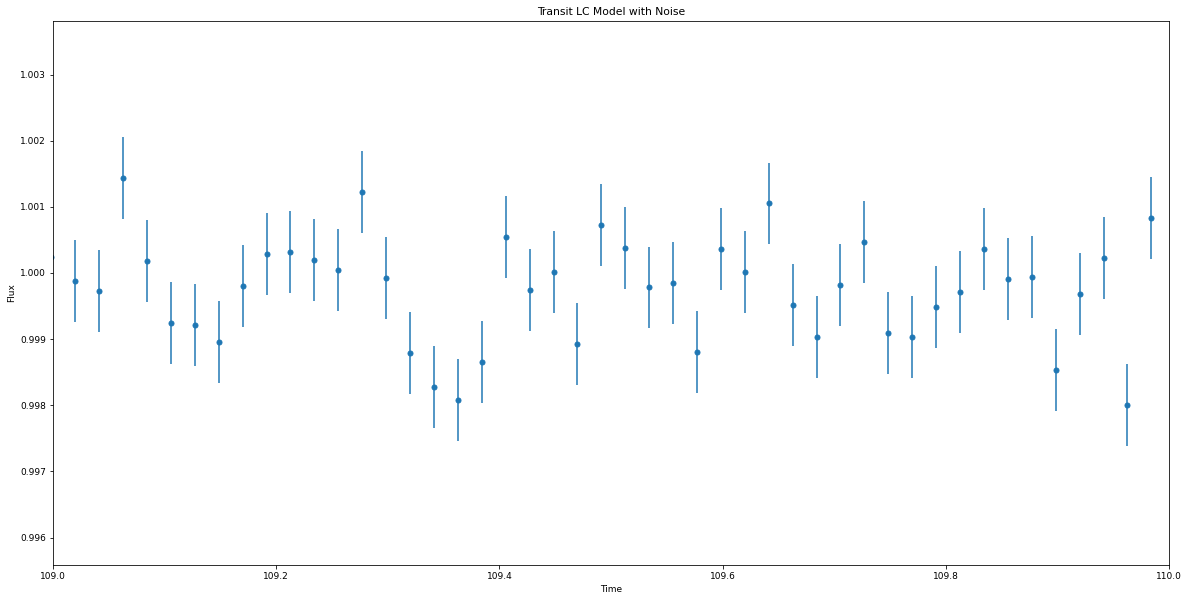

In [26]:
plt.errorbar(time-2454900, nflux, yerr=flux_err, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(109,110)
plt.title('Transit LC Model with Noise')

## Fitting the transit


`photoeccentric` includes functionality to fit using `juliet` with `multinest`.

First, I'll fit the transit shape with `juliet`. $Rp/Rs$, $a/Rs$, $i$, and $w$ are allowed to vary as free parameters. 

The transit fitter, `ph.planetlc_fitter`, fixes $e = 0.0$, even if the input eccentricity is not zero! This means that if e is not 0, the transit fitter will fit the "wrong" values for $a/Rs$ and $i$ -- but they will be wrong in such a way that reveals the eccentricity of the orbit. More on that in the next section.

I enter an initial guess based on what I estimate the fit parameters will be. For this one, I'll enter values close to the Kepler archive parameters.

##### Removing Out of Transit Data

In [27]:
koi.time = time
koi.flux = nflux
koi.flux_err = flux_err

Let's just do the first 7 transits.

In [28]:
koi.midpoints = koi.midpoints[0:7]

In [29]:
koi.remove_oot_data(7, 6)

Text(0.5, 1.0, 'Transit LC Model with Noise')

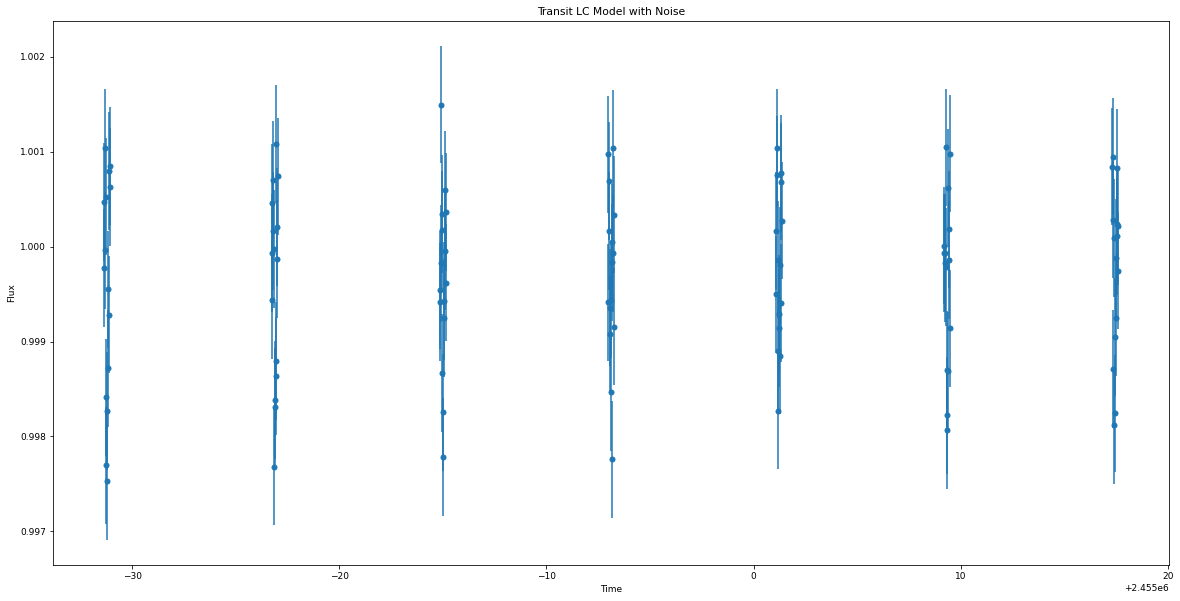

In [30]:
plt.errorbar(koi.time_intransit, koi.flux_intransit, yerr=koi.fluxerr_intransit, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Transit LC Model with Noise')

In [31]:
nlive=1000
nsupersample=29
exptimesupersample=0.0201389

In [32]:
dataset, results = koi.do_tfit_juliet(direct, nsupersample=nsupersample, exptimesupersample=exptimesupersample, nlive=nlive)

Fitting KOI 818.01
  analysing data from tutorial/818.01/e_0.0_w_90.0/jomnest_.txt


In [33]:
res = pd.read_table(direct + 'posteriors.dat')

In [34]:
# Print transit fit results from Juliet
res

,# Parameter Name,,Median,.1,Upper 68 CI,.2,Lower 68 CI
0,P_p1,,8.11226,,0.00124,,0.00126
1,t0_p1,,2455009.34088,,0.00372,,0.00398
2,p_p1,,0.03832,,0.00229,,0.00229
3,b_p1,,0.33712,,0.25833,,0.22439
4,q1_KEPLER,,0.50266,,0.32074,,0.30654
5,q2_KEPLER,,0.46850,,0.33069,,0.31063
6,a_p1,,22.22587,,2.74053,,3.13032
7,mflux_KEPLER,,-0.00019,,0.00008,,0.00008
8,sigma_w_KEPLER,,3.92579,,52.73840,,3.59434


In [35]:
# Save fit planet parameters to variables for convenience
per_f = res.iloc[0][2]
t0_f = res.iloc[1][2]
rprs_f = res.iloc[2][2]
b_f = res.iloc[3][2]
a_f = res.iloc[6][2]

i_f = np.arccos(b_f*(1./a_f))*(180./np.pi)


Below, I print the original parameters and fit parameters, and overlay the fit light curve on the input light curve. 

Because I input $e = 0.0$, the transit fitter should return the exact same parameters I input (because the transit fitter always requires $e = 0.0$).

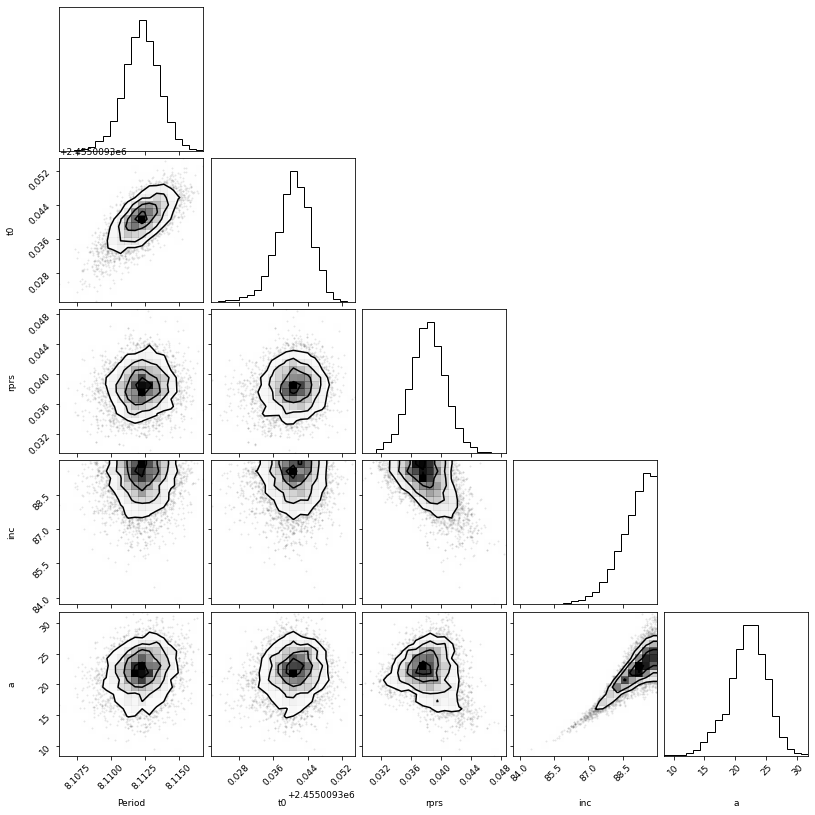

In [36]:
# Plot the transit fit corner plot
p = results.posteriors['posterior_samples']['P_p1']
t0 = results.posteriors['posterior_samples']['t0_p1']
rprs = results.posteriors['posterior_samples']['p_p1']
b = results.posteriors['posterior_samples']['b_p1']
a = results.posteriors['posterior_samples']['a_p1']
inc = np.arccos(b*(1./a))*(180./np.pi)

params = ['Period', 't0', 'rprs', 'inc', 'a']

fs = np.vstack((p, t0, rprs, inc, a))
fs = fs.T

figure = corner.corner(fs, labels=params)

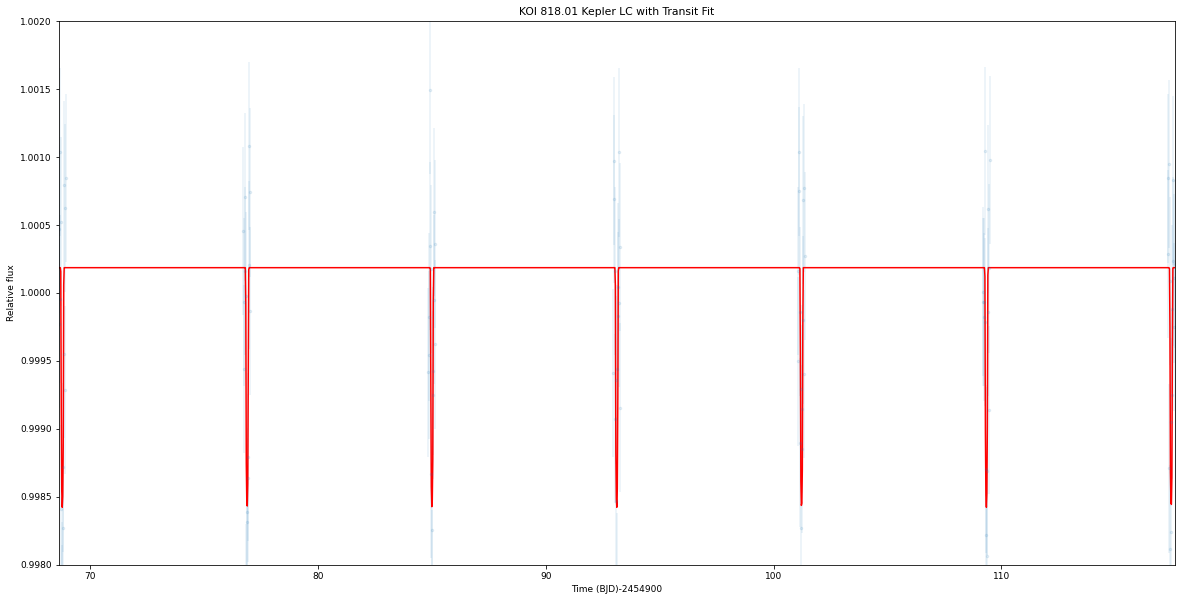

In [37]:
# Plot the data:
plt.errorbar(dataset.times_lc['KEPLER']-2454900, dataset.data_lc['KEPLER'], \
             yerr = dataset.errors_lc['KEPLER'], fmt = '.', alpha = 0.1)

# Plot the model:
plt.plot(dataset.times_lc['KEPLER']-2454900, results.lc.evaluate('KEPLER'), c='r')

# Plot portion of the lightcurve, axes, etc.:
plt.xlabel('Time (BJD)-2454900')
plt.xlim(np.min(dataset.times_lc['KEPLER'])-2454900, np.max(dataset.times_lc['KEPLER'])-2454900)
plt.ylim(0.998, 1.002)
plt.ylabel('Relative flux')
plt.title('KOI 818.01 Kepler LC with Transit Fit')
plt.show()

### Determining T14 and T23

A crucial step to determining the $(e, w)$ distribution from the transit is calculating the total and full transit durations. T14 is the total transit duration (the time between first and fourth contact). T23 is the full transit duration (i.e. the time during which the entire planet disk is in front of the star, the time between second and third contact.)


Here, I'm using equations 14 and 15 from [this textbook](https://sites.astro.caltech.edu/~lah/review/transits_occultations.winn.pdf). We calculate T14 and T23 assuming the orbit must be circular, and using the fit parameters assuming the orbit is circular. (If the orbit is not circular, T14 and T23 will not be correct -- but this is what we want, because they will differ from the true T14 and T23 in a way that reveals the eccentricity of the orbit.)

In [38]:
koi.calc_durations()

In [39]:
print('Total Transit Duration: ', np.mean(koi.T14_dist), koi.T14_errs)
print('Full Transit Duration: ', np.mean(koi.T23_dist), koi.T23_errs)

Total Transit Duration:  0.11214203271552389 (0.009074328077622193, 0.01008020097475372)
Full Transit Duration:  0.10149275417258226 (0.009142889397238452, 0.009728546427558826)


# Get $g$

Finally, we can use all the values above to determine $\rho_{circ}$. $\rho_{circ}$ is what we would calculate the stellar density to be if we knew that the orbit was definitely perfectly circular. We  will compare $\rho_{circ}$ to $\rho_{star}$ (the true, observed stellar density we calculated from spectroscopy/Gaia), and get $g(e, w)$:
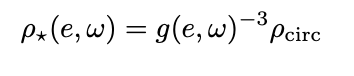

which is also defined as 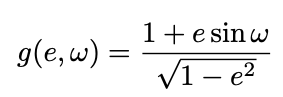

Thus, if the orbit is circular $(e = 0)$, then $g$ should equal 1. If the orbit is not circular $(e != 0)$, then $\rho_{circ}$ should differ from $\rho_{star}$, and $g$ should be something other than 1. We can draw a $(e, w)$ distribution based on the value we calcaulte for $g(e,w)$!

`ph.get_g_distribution()` will help us determine the value of g. This function takes the observed $\rho_{star}$ as well as the fit (circular) transit parameters and calculated transit durations, and calculates $\rho_{circ}$ and $g(e,w)$ based on equations 6 and 7 in [Dawson & Johnson 2012](https://arxiv.org/pdf/1203.5537.pdf).

Print $g$ and $\sigma_{g}$:

In [40]:
koi.get_gs()

In [41]:
g_mean = koi.g_mean
g_sigma = koi.g_sigma

In [42]:
g_mean

0.78264825786002

In [43]:
g_sigma

0.14120091109360605

The mean of $g$ is about 1.0, which means that $\rho_{circ}$ agrees with $\rho_{star}$ and the eccentricity of this transit must be zero, which is exactly what we input! We can take $g$ and $\sigma_{g}$ and use MCMC (`emcee`) to determine the surface of most likely $(e,w)$.

`photoeccentric` has the probability function for $(e,w)$ from $g$ built in to `ph.log_probability()`.

In [44]:
koi.do_eccfit(direct)

15833it [01:10, 225.67it/s, batch: 11 | bound: 0 | nc: 3 | ncall: 100692 | eff(%): 15.724 | loglstar:  0.318 <  1.958 <  1.874 | logz:  0.607 +/-  0.050 | stop:  0.976]         

Code and Methods:
Speagle (2020): ui.adsabs.harvard.edu/abs/2019arXiv190402180S

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944

Dynamic Nested Sampling:
Higson et al. (2019): doi.org/10.1007/s11222-018-9844-0

Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:
Skilling (2006): projecteuclid.org/euclid.ba/1340370944



In [45]:
with open(direct + '/kepewdres.pickle', 'rb') as f:
    ewdres = pickle.load(f)

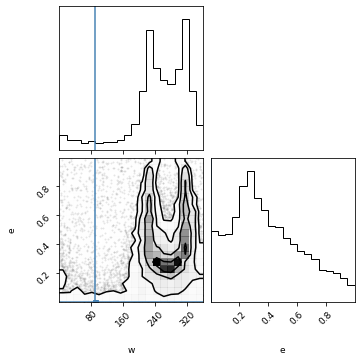

In [46]:
labels = ["w", "e"]

fig = corner.corner(ewdres.samples, labels=labels, title_kwargs={"fontsize": 12}, truths=[w, e], plot_contours=True)

And here is the corner plot for the most likely values of $(e, w)$ that correspond to $g = 1$. The $e$ distribution peaks at 0!

## $e = 0.3$, $\omega = 90.0$

Now let's repeat this example with an eccentricity of 0.3 at periapse.

In [47]:
# Define the working directory
direct = 'tutorial/' + str(nkoi) + '/e_0.3_w_90.0/'

In [48]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(starttime, endtime, cadence)

In [49]:
# Define e and w, calculate flux from transit model
e = 0.3
w = 90.0

params = batman.TransitParams()       #object to store transit parameters
params.t0 = koi.epoch                        #time of inferior conjunction
params.per = koi.period                       #orbital period
params.rp = koi.rprs                       #planet radius (in units of stellar radii)
params.a = koi.a_rs                        #semi-major axis (in units of stellar radii)
params.inc = koi.i                      #orbital inclination (in degrees)
params.ecc = e                       #eccentricity
params.w = w                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = time
m = batman.TransitModel(params, t, supersample_factor = 29, exp_time = 0.0201389)

In [50]:
flux = m.light_curve(params)

Text(0.5, 1.0, 'Transit LC Model')

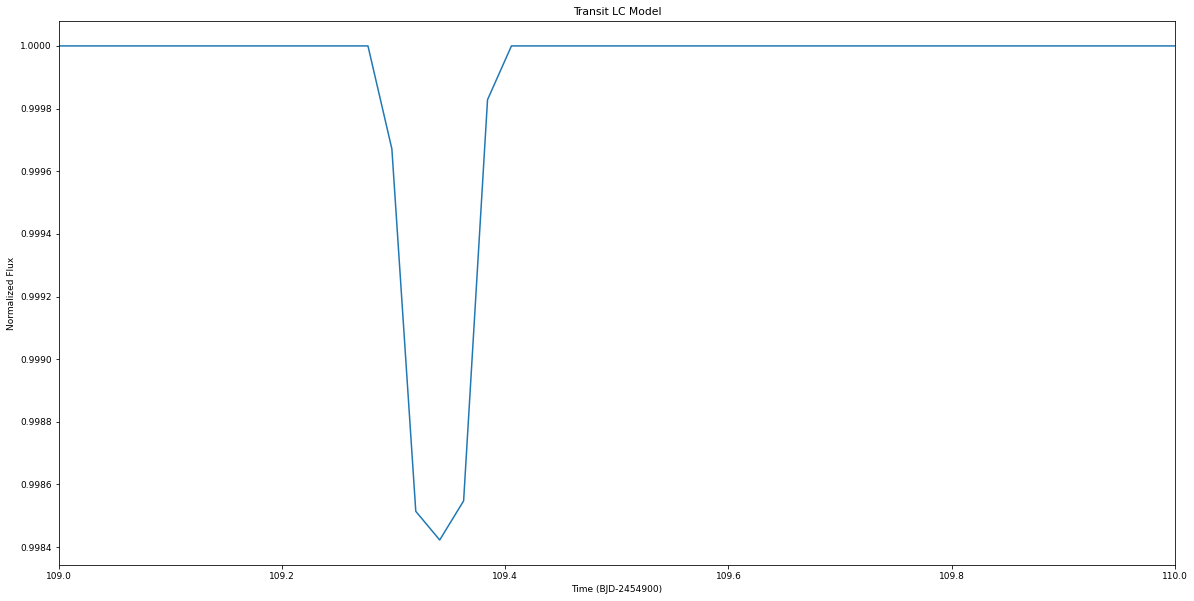

In [51]:
time = time
flux = flux

plt.plot(time-2454900, flux)
plt.xlim(109,110)
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Normalized Flux')
plt.title('Transit LC Model')

To create a light curve with a target signal to noise ratio, we need the transit duration, number of transits, and the number of points in each transit, and the transit depth.

In [52]:
tduration = koi.dur/24.0

N = round(ph.get_N_intransit(tduration, cadence))
ntransits = len(koi.midpoints)
depth = koi.rprs**2

The magnitude of each individual error bar:

In [53]:
errbar = ph.get_sigma_individual(60, N, ntransits, depth)

Adding gaussian noise to produce a light curve with the target SNR:

(NB: the noise is gaussian and uncorrelated, unlike the noise in real Kepler light curves)

In [54]:
noise = np.random.normal(0,errbar,len(time))
nflux = flux+noise

flux_err = np.array([errbar]*len(nflux))

Text(0.5, 1.0, 'Transit LC Model with Noise')

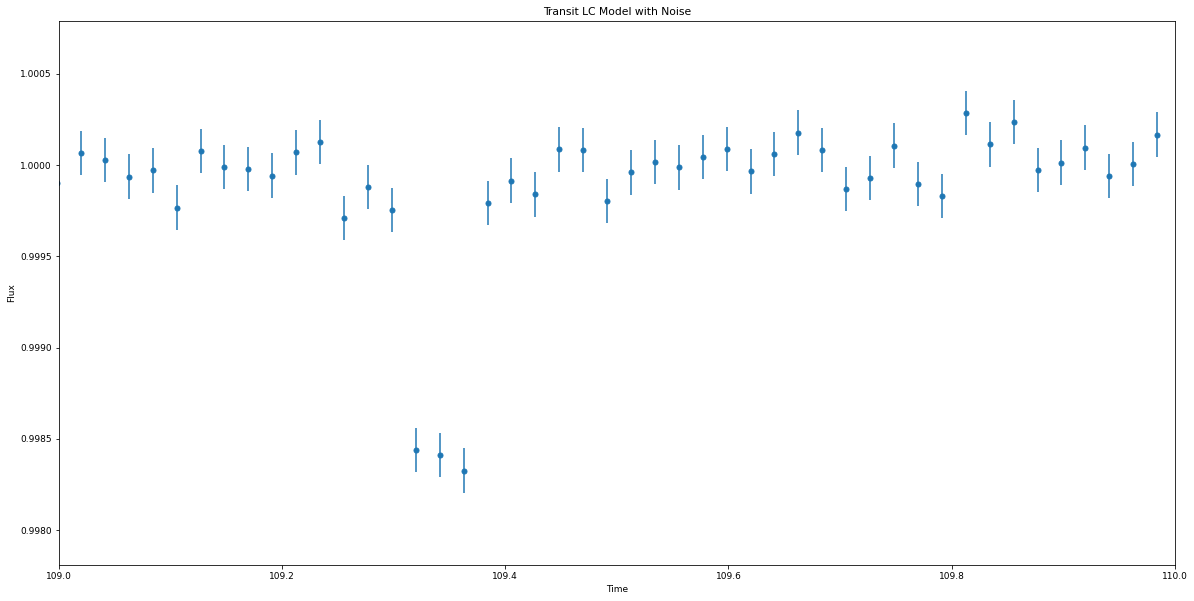

In [55]:
plt.errorbar(time-2454900, nflux, yerr=flux_err, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(109,110)
plt.title('Transit LC Model with Noise')

## Fitting the transit


`photoeccentric` includes functionality to fit using `juliet` with `multinest`.

First, I'll fit the transit shape with `juliet`. $Rp/Rs$, $a/Rs$, $i$, and $w$ are allowed to vary as free parameters. 

The transit fitter, `ph.planetlc_fitter`, fixes $e = 0.0$, even if the input eccentricity is not zero! This means that if e is not 0, the transit fitter will fit the "wrong" values for $a/Rs$ and $i$ -- but they will be wrong in such a way that reveals the eccentricity of the orbit. More on that in the next section.

I enter an initial guess based on what I estimate the fit parameters will be. For this one, I'll enter values close to the Kepler archive parameters.

##### Removing Out of Transit Data

In [56]:
koi.time = time
koi.flux = nflux
koi.flux_err = flux_err

Let's just do the first 7 transits.

In [57]:
koi.midpoints = koi.midpoints[0:7]

In [58]:
koi.remove_oot_data(7, 6)

Text(0.5, 1.0, 'Transit LC Model with Noise')

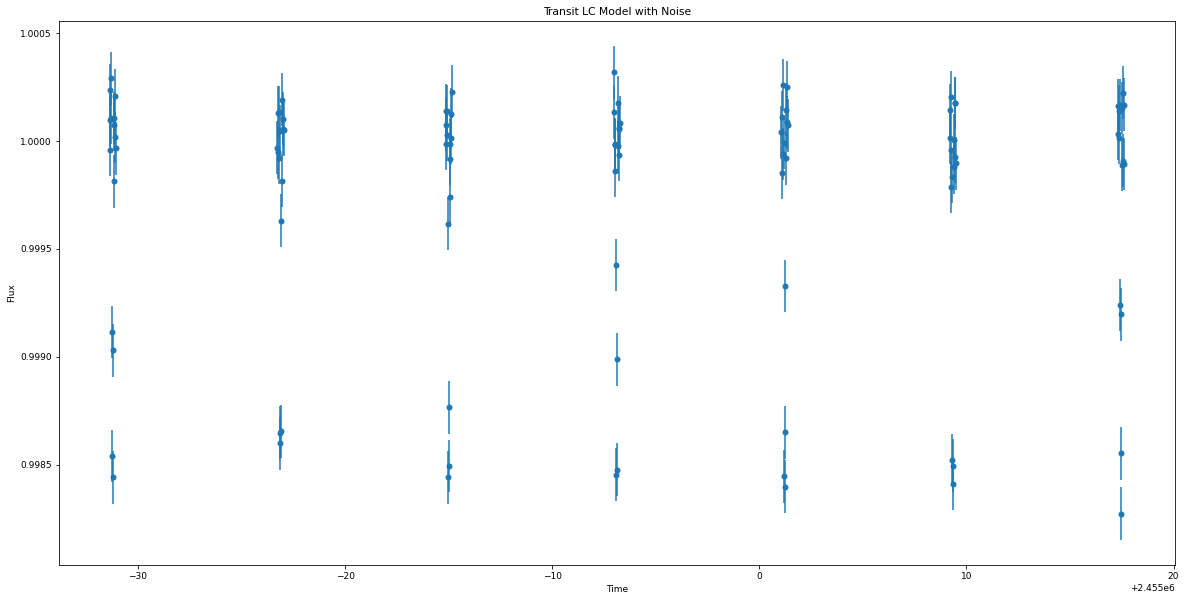

In [59]:
plt.errorbar(koi.time_intransit, koi.flux_intransit, yerr=koi.fluxerr_intransit, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Transit LC Model with Noise')

In [60]:
nlive=1000
nsupersample=29
exptimesupersample=0.0201389

In [61]:
dataset, results = koi.do_tfit_juliet(direct, nsupersample=nsupersample, exptimesupersample=exptimesupersample, nlive=nlive)

Fitting KOI 818.01
  analysing data from tutorial/818.01/e_0.3_w_90.0/jomnest_.txt


In [62]:
res = pd.read_table(direct + 'posteriors.dat')

In [63]:
# Print transit fit results from Juliet
res

,# Parameter Name,,Median,.1,Upper 68 CI,.2,Lower 68 CI
0,P_p1,,8.11452,,0.00023,,0.00021
1,t0_p1,,2455009.33937,,0.00062,,0.00063
2,p_p1,,0.03809,,0.00097,,0.00105
3,b_p1,,0.34853,,0.26925,,0.23012
4,q1_KEPLER,,0.17705,,0.30725,,0.12297
5,q2_KEPLER,,0.23627,,0.34725,,0.17349
6,a_p1,,33.21021,,2.06751,,4.97506
7,mflux_KEPLER,,-0.00005,,0.00001,,0.00001
8,sigma_w_KEPLER,,2.76826,,22.64271,,2.45362


In [64]:
# Save fit planet parameters to variables for convenience
per_f = res.iloc[0][2]
t0_f = res.iloc[1][2]
rprs_f = res.iloc[2][2]
b_f = res.iloc[3][2]
a_f = res.iloc[6][2]

i_f = np.arccos(b_f*(1./a_f))*(180./np.pi)


Below, I print the original parameters and fit parameters, and overlay the fit light curve on the input light curve. 

Because I input $e = 0.0$, the transit fitter should return the exact same parameters I input (because the transit fitter always requires $e = 0.0$).

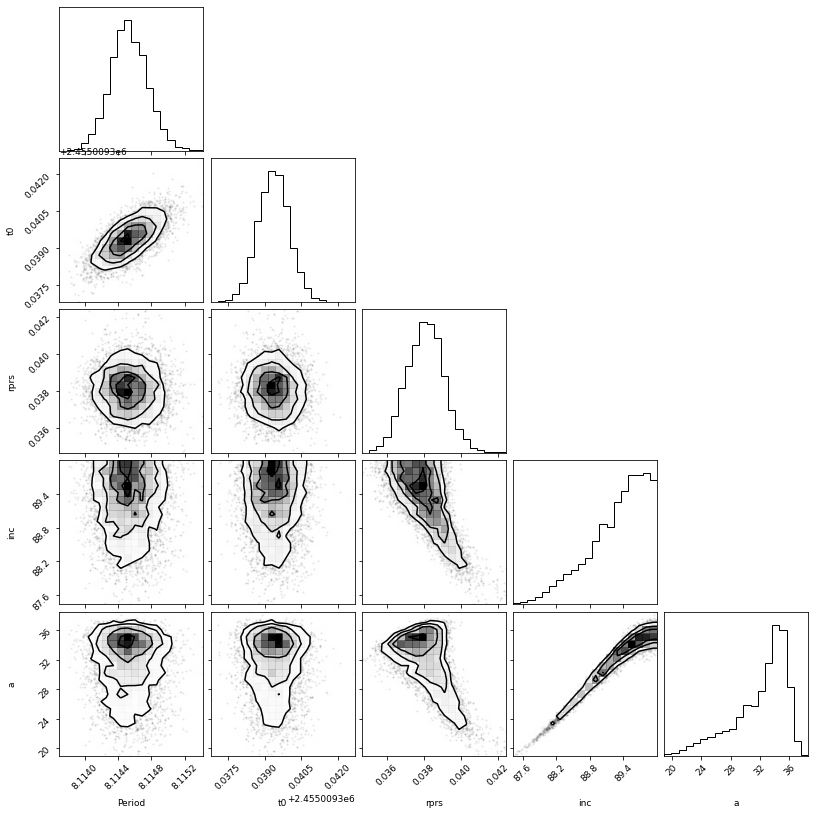

In [65]:
# Plot the transit fit corner plot
p = results.posteriors['posterior_samples']['P_p1']
t0 = results.posteriors['posterior_samples']['t0_p1']
rprs = results.posteriors['posterior_samples']['p_p1']
b = results.posteriors['posterior_samples']['b_p1']
a = results.posteriors['posterior_samples']['a_p1']
inc = np.arccos(b*(1./a))*(180./np.pi)

params = ['Period', 't0', 'rprs', 'inc', 'a']

fs = np.vstack((p, t0, rprs, inc, a))
fs = fs.T

figure = corner.corner(fs, labels=params)

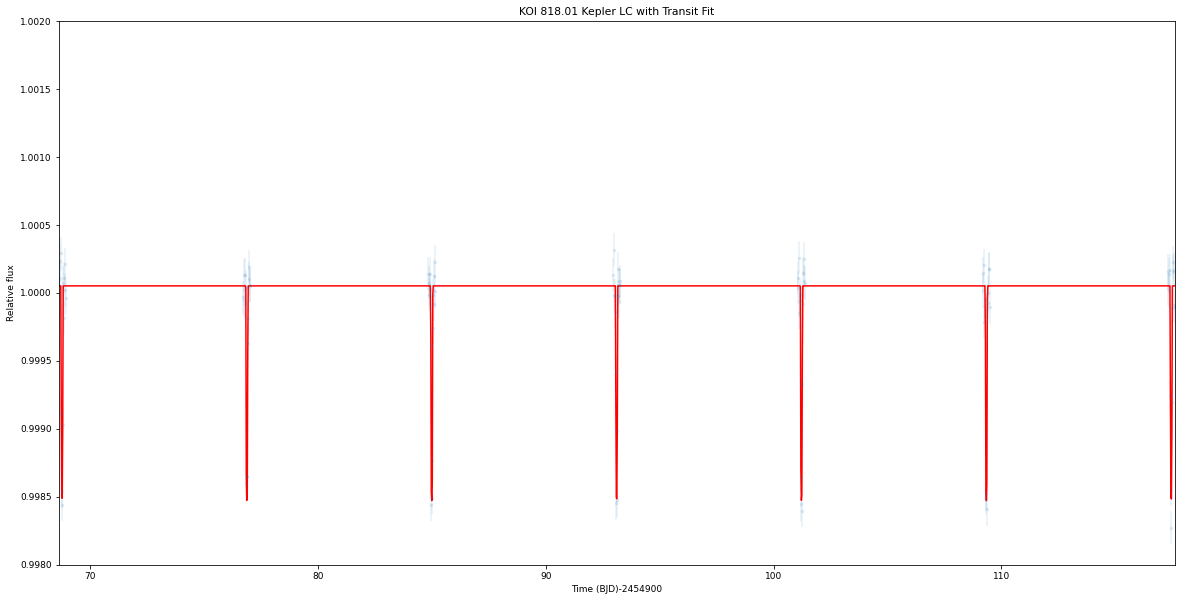

In [66]:
# Plot the data:
plt.errorbar(dataset.times_lc['KEPLER']-2454900, dataset.data_lc['KEPLER'], \
             yerr = dataset.errors_lc['KEPLER'], fmt = '.', alpha = 0.1)

# Plot the model:
plt.plot(dataset.times_lc['KEPLER']-2454900, results.lc.evaluate('KEPLER'), c='r')

# Plot portion of the lightcurve, axes, etc.:
plt.xlabel('Time (BJD)-2454900')
plt.xlim(np.min(dataset.times_lc['KEPLER'])-2454900, np.max(dataset.times_lc['KEPLER'])-2454900)
plt.ylim(0.998, 1.002)
plt.ylabel('Relative flux')
plt.title('KOI 818.01 Kepler LC with Transit Fit')
plt.show()

### Determining T14 and T23

A crucial step to determining the $(e, w)$ distribution from the transit is calculating the total and full transit durations. T14 is the total transit duration (the time between first and fourth contact). T23 is the full transit duration (i.e. the time during which the entire planet disk is in front of the star, the time between second and third contact.)


Here, I'm using equations 14 and 15 from [this textbook](https://sites.astro.caltech.edu/~lah/review/transits_occultations.winn.pdf). We calculate T14 and T23 assuming the orbit must be circular, and using the fit parameters assuming the orbit is circular. (If the orbit is not circular, T14 and T23 will not be correct -- but this is what we want, because they will differ from the true T14 and T23 in a way that reveals the eccentricity of the orbit.)

In [67]:
koi.calc_durations()

In [68]:
print('Total Transit Duration: ', np.mean(koi.T14_dist), koi.T14_errs)
print('Full Transit Duration: ', np.mean(koi.T23_dist), koi.T23_errs)

Total Transit Duration:  0.07616815216249453 (0.0019461796163439543, 0.0022887898875228047)
Full Transit Duration:  0.06894928687607373 (0.0023735171102194363, 0.0023828588410691465)


# Get $g$

Finally, we can use all the values above to determine $\rho_{circ}$. $\rho_{circ}$ is what we would calculate the stellar density to be if we knew that the orbit was definitely perfectly circular. We  will compare $\rho_{circ}$ to $\rho_{star}$ (the true, observed stellar density we calculated from spectroscopy/Gaia), and get $g(e, w)$:
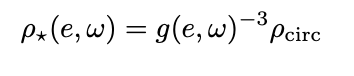

which is also defined as 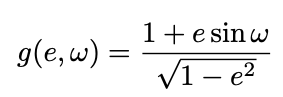

Thus, if the orbit is circular $(e = 0)$, then $g$ should equal 1. If the orbit is not circular $(e != 0)$, then $\rho_{circ}$ should differ from $\rho_{star}$, and $g$ should be something other than 1. We can draw a $(e, w)$ distribution based on the value we calcaulte for $g(e,w)$!

`ph.get_g_distribution()` will help us determine the value of g. This function takes the observed $\rho_{star}$ as well as the fit (circular) transit parameters and calculated transit durations, and calculates $\rho_{circ}$ and $g(e,w)$ based on equations 6 and 7 in [Dawson & Johnson 2012](https://arxiv.org/pdf/1203.5537.pdf).

Print $g$ and $\sigma_{g}$:

In [69]:
koi.get_gs()

In [70]:
g_mean = koi.g_mean
g_sigma = koi.g_sigma

In [71]:
g_mean

1.3206329050193686

In [72]:
g_sigma

0.142566640499177

The mean of $g$ is about 1.0, which means that $\rho_{circ}$ agrees with $\rho_{star}$ and the eccentricity of this transit must be zero, which is exactly what we input! We can take $g$ and $\sigma_{g}$ and use MCMC (`emcee`) to determine the surface of most likely $(e,w)$.

`photoeccentric` has the probability function for $(e,w)$ from $g$ built in to `ph.log_probability()`.

In [73]:
koi.do_eccfit(direct)

16439it [01:14, 221.88it/s, batch: 11 | bound: 0 | nc: 1 | ncall: 128148 | eff(%): 12.828 | loglstar:   -inf <  1.948 <  1.879 | logz:  0.250 +/-  0.061 | stop:  0.991]         

Code and Methods:
Speagle (2020): ui.adsabs.harvard.edu/abs/2019arXiv190402180S

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944

Dynamic Nested Sampling:
Higson et al. (2019): doi.org/10.1007/s11222-018-9844-0

Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:
Skilling (2006): projecteuclid.org/euclid.ba/1340370944



In [74]:
with open(direct + '/kepewdres.pickle', 'rb') as f:
    ewdres = pickle.load(f)

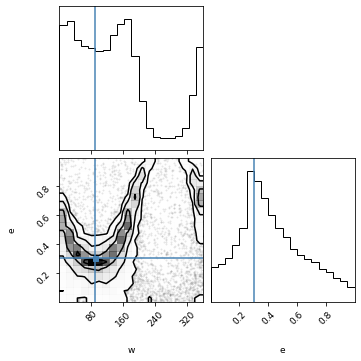

In [75]:
labels = ["w", "e"]

fig = corner.corner(ewdres.samples, labels=labels, title_kwargs={"fontsize": 12}, truths=[w, e], plot_contours=True)

And here is the corner plot for the most likely values of $(e, w)$ that correspond to $g = 1$. The $e$ distribution peaks at 0!

## $e = 0.3$, $\omega = 90.0$

Now let's repeat this example with an eccentricity of 0.3 at periapse.

In [76]:
# Define the working directory
direct = 'tutorial/' + str(nkoi) + '/e_0.3_w_90.0/'

In [77]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(starttime, endtime, cadence)

In [78]:
# Define e and w, calculate flux from transit model
e = 0.3
w = 90.0

params = batman.TransitParams()       #object to store transit parameters
params.t0 = koi.epoch                        #time of inferior conjunction
params.per = koi.period                       #orbital period
params.rp = koi.rprs                       #planet radius (in units of stellar radii)
params.a = koi.a_rs                        #semi-major axis (in units of stellar radii)
params.inc = koi.i                      #orbital inclination (in degrees)
params.ecc = e                       #eccentricity
params.w = w                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = time
m = batman.TransitModel(params, t, supersample_factor = 29, exp_time = 0.0201389)

In [79]:
flux = m.light_curve(params)

Text(0.5, 1.0, 'Transit LC Model')

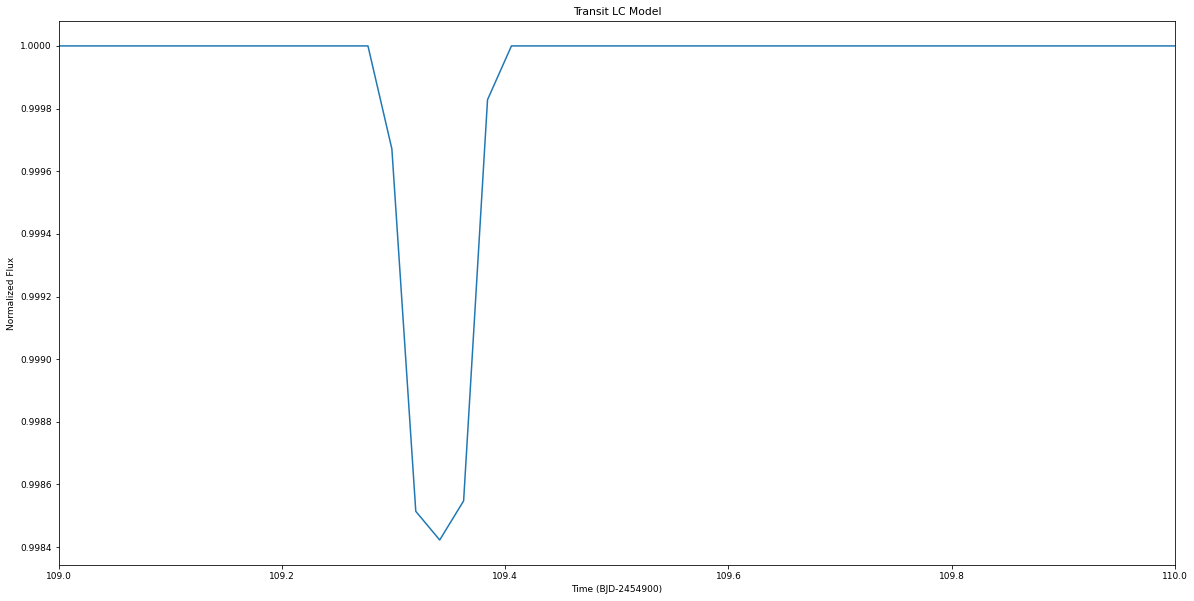

In [80]:
time = time
flux = flux

plt.plot(time-2454900, flux)
plt.xlim(109,110)
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Normalized Flux')
plt.title('Transit LC Model')

To create a light curve with a target signal to noise ratio, we need the transit duration, number of transits, and the number of points in each transit, and the transit depth.

In [81]:
tduration = koi.dur/24.0

N = round(ph.get_N_intransit(tduration, cadence))
ntransits = len(koi.midpoints)
depth = koi.rprs**2

The magnitude of each individual error bar:

In [82]:
errbar = ph.get_sigma_individual(60, N, ntransits, depth)

Adding gaussian noise to produce a light curve with the target SNR:

(NB: the noise is gaussian and uncorrelated, unlike the noise in real Kepler light curves)

In [83]:
noise = np.random.normal(0,errbar,len(time))
nflux = flux+noise

flux_err = np.array([errbar]*len(nflux))

Text(0.5, 1.0, 'Transit LC Model with Noise')

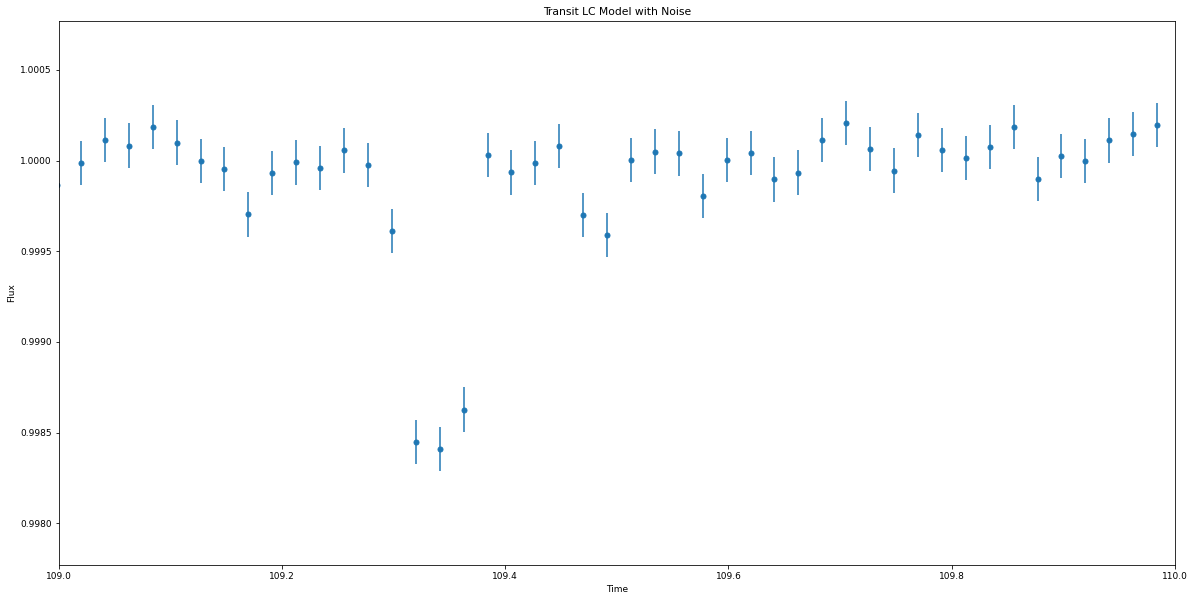

In [84]:
plt.errorbar(time-2454900, nflux, yerr=flux_err, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(109,110)
plt.title('Transit LC Model with Noise')

## Fitting the transit


`photoeccentric` includes functionality to fit using `juliet` with `multinest`.

First, I'll fit the transit shape with `juliet`. $Rp/Rs$, $a/Rs$, $i$, and $w$ are allowed to vary as free parameters. 

The transit fitter, `ph.planetlc_fitter`, fixes $e = 0.0$, even if the input eccentricity is not zero! This means that if e is not 0, the transit fitter will fit the "wrong" values for $a/Rs$ and $i$ -- but they will be wrong in such a way that reveals the eccentricity of the orbit. More on that in the next section.

I enter an initial guess based on what I estimate the fit parameters will be. For this one, I'll enter values close to the Kepler archive parameters.

##### Removing Out of Transit Data

In [85]:
koi.time = time
koi.flux = nflux
koi.flux_err = flux_err

Let's just do the first 7 transits.

In [86]:
koi.midpoints = koi.midpoints[0:7]

In [87]:
koi.remove_oot_data(7, 6)

Text(0.5, 1.0, 'Transit LC Model with Noise')

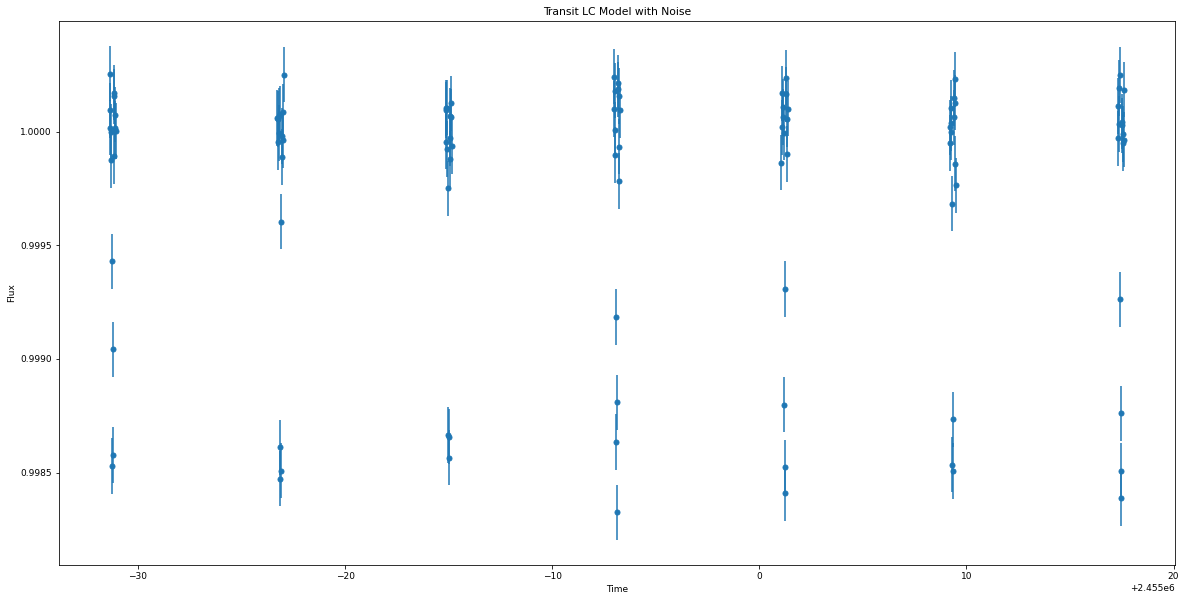

In [88]:
plt.errorbar(koi.time_intransit, koi.flux_intransit, yerr=koi.fluxerr_intransit, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Transit LC Model with Noise')

In [89]:
nlive=1000
nsupersample=29
exptimesupersample=0.0201389

In [90]:
dataset, results = koi.do_tfit_juliet(direct, nsupersample=nsupersample, exptimesupersample=exptimesupersample, nlive=nlive)

Fitting KOI 818.01
Detected multinest sampler output files --- extracting from tutorial/818.01/e_0.3_w_90.0/posteriors.pkl


In [91]:
res = pd.read_table(direct + 'posteriors.dat')

In [92]:
# Print transit fit results from Juliet
res

,# Parameter Name,,Median,.1,Upper 68 CI,.2,Lower 68 CI
0,P_p1,,8.11452,,0.00023,,0.00021
1,t0_p1,,2455009.33937,,0.00062,,0.00063
2,p_p1,,0.03809,,0.00097,,0.00105
3,b_p1,,0.34853,,0.26925,,0.23012
4,q1_KEPLER,,0.17705,,0.30725,,0.12297
5,q2_KEPLER,,0.23627,,0.34725,,0.17349
6,a_p1,,33.21021,,2.06751,,4.97506
7,mflux_KEPLER,,-0.00005,,0.00001,,0.00001
8,sigma_w_KEPLER,,2.76826,,22.64271,,2.45362


In [93]:
# Save fit planet parameters to variables for convenience
per_f = res.iloc[0][2]
t0_f = res.iloc[1][2]
rprs_f = res.iloc[2][2]
b_f = res.iloc[3][2]
a_f = res.iloc[6][2]

i_f = np.arccos(b_f*(1./a_f))*(180./np.pi)


Below, I print the original parameters and fit parameters, and overlay the fit light curve on the input light curve. 

Because I input $e = 0.0$, the transit fitter should return the exact same parameters I input (because the transit fitter always requires $e = 0.0$).

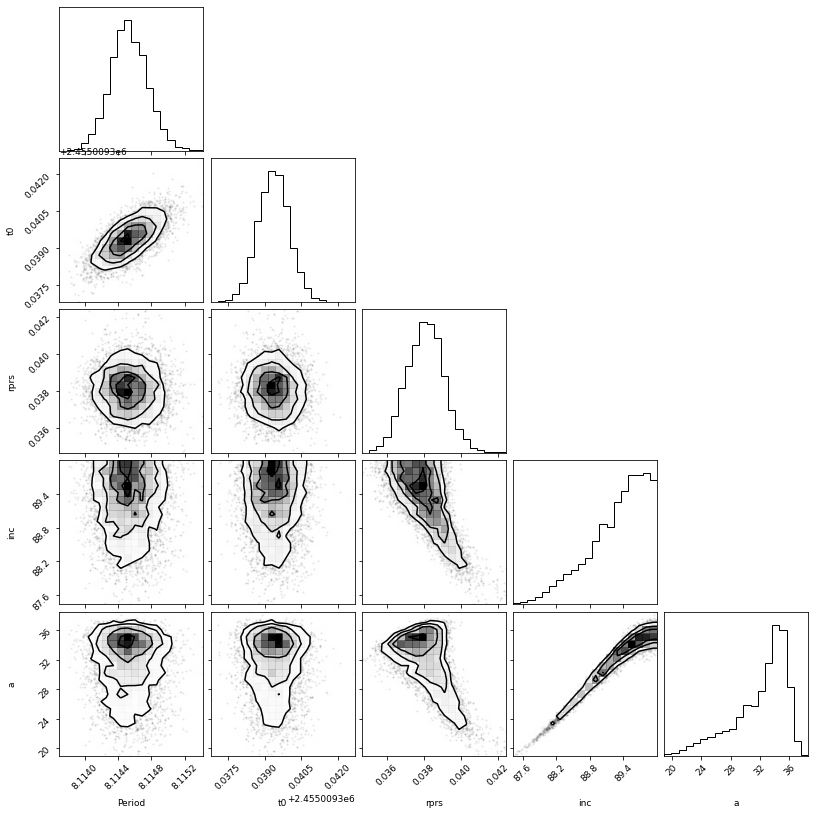

In [94]:
# Plot the transit fit corner plot
p = results.posteriors['posterior_samples']['P_p1']
t0 = results.posteriors['posterior_samples']['t0_p1']
rprs = results.posteriors['posterior_samples']['p_p1']
b = results.posteriors['posterior_samples']['b_p1']
a = results.posteriors['posterior_samples']['a_p1']
inc = np.arccos(b*(1./a))*(180./np.pi)

params = ['Period', 't0', 'rprs', 'inc', 'a']

fs = np.vstack((p, t0, rprs, inc, a))
fs = fs.T

figure = corner.corner(fs, labels=params)

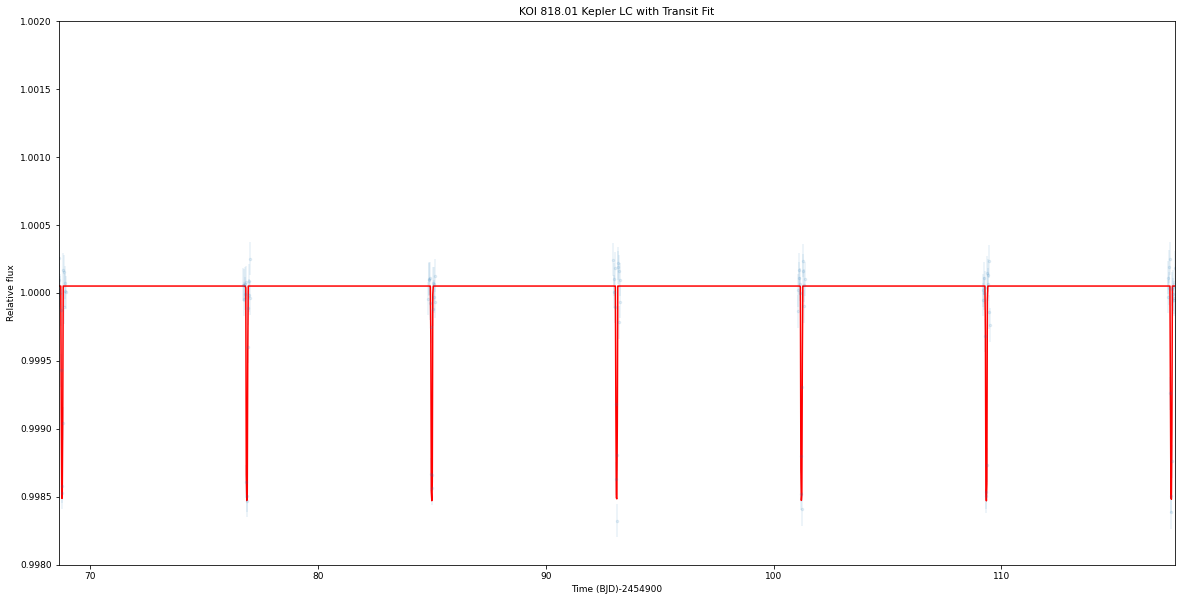

In [95]:
# Plot the data:
plt.errorbar(dataset.times_lc['KEPLER']-2454900, dataset.data_lc['KEPLER'], \
             yerr = dataset.errors_lc['KEPLER'], fmt = '.', alpha = 0.1)

# Plot the model:
plt.plot(dataset.times_lc['KEPLER']-2454900, results.lc.evaluate('KEPLER'), c='r')

# Plot portion of the lightcurve, axes, etc.:
plt.xlabel('Time (BJD)-2454900')
plt.xlim(np.min(dataset.times_lc['KEPLER'])-2454900, np.max(dataset.times_lc['KEPLER'])-2454900)
plt.ylim(0.998, 1.002)
plt.ylabel('Relative flux')
plt.title('KOI 818.01 Kepler LC with Transit Fit')
plt.show()

### Determining T14 and T23

A crucial step to determining the $(e, w)$ distribution from the transit is calculating the total and full transit durations. T14 is the total transit duration (the time between first and fourth contact). T23 is the full transit duration (i.e. the time during which the entire planet disk is in front of the star, the time between second and third contact.)


Here, I'm using equations 14 and 15 from [this textbook](https://sites.astro.caltech.edu/~lah/review/transits_occultations.winn.pdf). We calculate T14 and T23 assuming the orbit must be circular, and using the fit parameters assuming the orbit is circular. (If the orbit is not circular, T14 and T23 will not be correct -- but this is what we want, because they will differ from the true T14 and T23 in a way that reveals the eccentricity of the orbit.)

In [96]:
koi.calc_durations()

In [97]:
print('Total Transit Duration: ', np.mean(koi.T14_dist), koi.T14_errs)
print('Full Transit Duration: ', np.mean(koi.T23_dist), koi.T23_errs)

Total Transit Duration:  0.07616815216249453 (0.0019461796163439543, 0.0022887898875228047)
Full Transit Duration:  0.06894928687607373 (0.0023735171102194363, 0.0023828588410691465)


# Get $g$

Finally, we can use all the values above to determine $\rho_{circ}$. $\rho_{circ}$ is what we would calculate the stellar density to be if we knew that the orbit was definitely perfectly circular. We  will compare $\rho_{circ}$ to $\rho_{star}$ (the true, observed stellar density we calculated from spectroscopy/Gaia), and get $g(e, w)$:
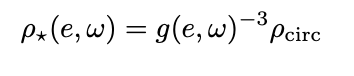

which is also defined as 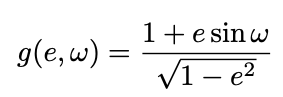

Thus, if the orbit is circular $(e = 0)$, then $g$ should equal 1. If the orbit is not circular $(e != 0)$, then $\rho_{circ}$ should differ from $\rho_{star}$, and $g$ should be something other than 1. We can draw a $(e, w)$ distribution based on the value we calcaulte for $g(e,w)$!

`ph.get_g_distribution()` will help us determine the value of g. This function takes the observed $\rho_{star}$ as well as the fit (circular) transit parameters and calculated transit durations, and calculates $\rho_{circ}$ and $g(e,w)$ based on equations 6 and 7 in [Dawson & Johnson 2012](https://arxiv.org/pdf/1203.5537.pdf).

Print $g$ and $\sigma_{g}$:

In [98]:
koi.get_gs()

In [99]:
g_mean = koi.g_mean
g_sigma = koi.g_sigma

In [100]:
g_mean

1.3206329050193686

In [101]:
g_sigma

0.142566640499177

The mean of $g$ is about 1.0, which means that $\rho_{circ}$ agrees with $\rho_{star}$ and the eccentricity of this transit must be zero, which is exactly what we input! We can take $g$ and $\sigma_{g}$ and use MCMC (`emcee`) to determine the surface of most likely $(e,w)$.

`photoeccentric` has the probability function for $(e,w)$ from $g$ built in to `ph.log_probability()`.

In [102]:
koi.do_eccfit(direct)

18102it [01:27, 206.67it/s, batch: 12 | bound: 0 | nc: 3 | ncall: 132846 | eff(%): 13.626 | loglstar:  0.416 <  1.948 <  1.859 | logz:  0.266 +/-  0.049 | stop:  0.959]          

Code and Methods:
Speagle (2020): ui.adsabs.harvard.edu/abs/2019arXiv190402180S

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944

Dynamic Nested Sampling:
Higson et al. (2019): doi.org/10.1007/s11222-018-9844-0

Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:
Skilling (2006): projecteuclid.org/euclid.ba/1340370944



In [103]:
with open(direct + '/kepewdres.pickle', 'rb') as f:
    ewdres = pickle.load(f)

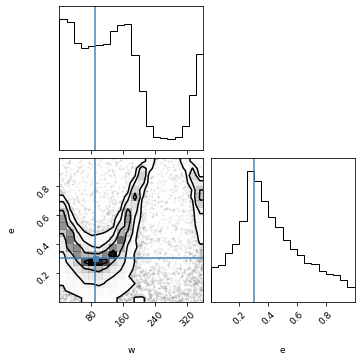

In [104]:
labels = ["w", "e"]

fig = corner.corner(ewdres.samples, labels=labels, title_kwargs={"fontsize": 12}, truths=[w, e], plot_contours=True)

And here is the corner plot for the most likely values of $(e, w)$ that correspond to $g = 1$. The $e$ distribution peaks at 0!

## $e = 0.3$, $\omega = 270.0$

Now let's repeat this example with an eccentricity of 0.3 at apoapse.

In [106]:
# Define the working directory
direct = 'tutorial/' + str(nkoi) + '/e_0.3_w_270.0/'

In [107]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(starttime, endtime, cadence)

In [109]:
# Define e and w, calculate flux from transit model
e = 0.3
w = 270.0

params = batman.TransitParams()       #object to store transit parameters
params.t0 = koi.epoch                        #time of inferior conjunction
params.per = koi.period                       #orbital period
params.rp = koi.rprs                       #planet radius (in units of stellar radii)
params.a = koi.a_rs                        #semi-major axis (in units of stellar radii)
params.inc = koi.i                      #orbital inclination (in degrees)
params.ecc = e                       #eccentricity
params.w = w                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = time
m = batman.TransitModel(params, t, supersample_factor = 29, exp_time = 0.0201389)

In [110]:
flux = m.light_curve(params)

Text(0.5, 1.0, 'Transit LC Model')

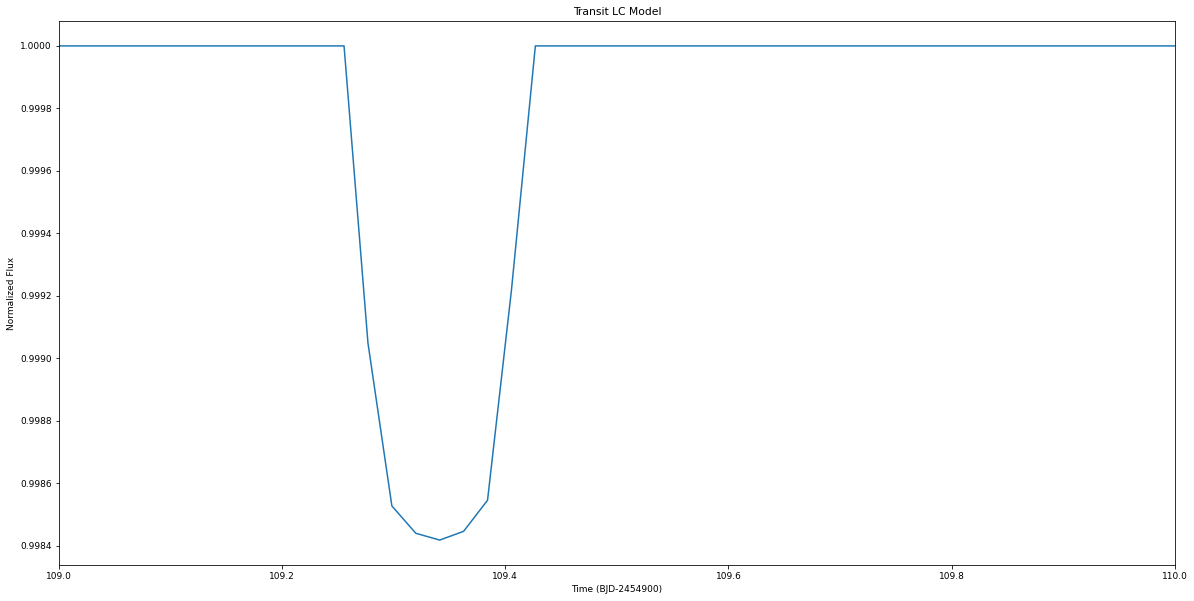

In [111]:
time = time
flux = flux

plt.plot(time-2454900, flux)
plt.xlim(109,110)
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Normalized Flux')
plt.title('Transit LC Model')

To create a light curve with a target signal to noise ratio, we need the transit duration, number of transits, and the number of points in each transit, and the transit depth.

In [112]:
tduration = koi.dur/24.0

N = round(ph.get_N_intransit(tduration, cadence))
ntransits = len(koi.midpoints)
depth = koi.rprs**2

The magnitude of each individual error bar:

In [113]:
errbar = ph.get_sigma_individual(60, N, ntransits, depth)

Adding gaussian noise to produce a light curve with the target SNR:

(NB: the noise is gaussian and uncorrelated, unlike the noise in real Kepler light curves)

In [114]:
noise = np.random.normal(0,errbar,len(time))
nflux = flux+noise

flux_err = np.array([errbar]*len(nflux))

Text(0.5, 1.0, 'Transit LC Model with Noise')

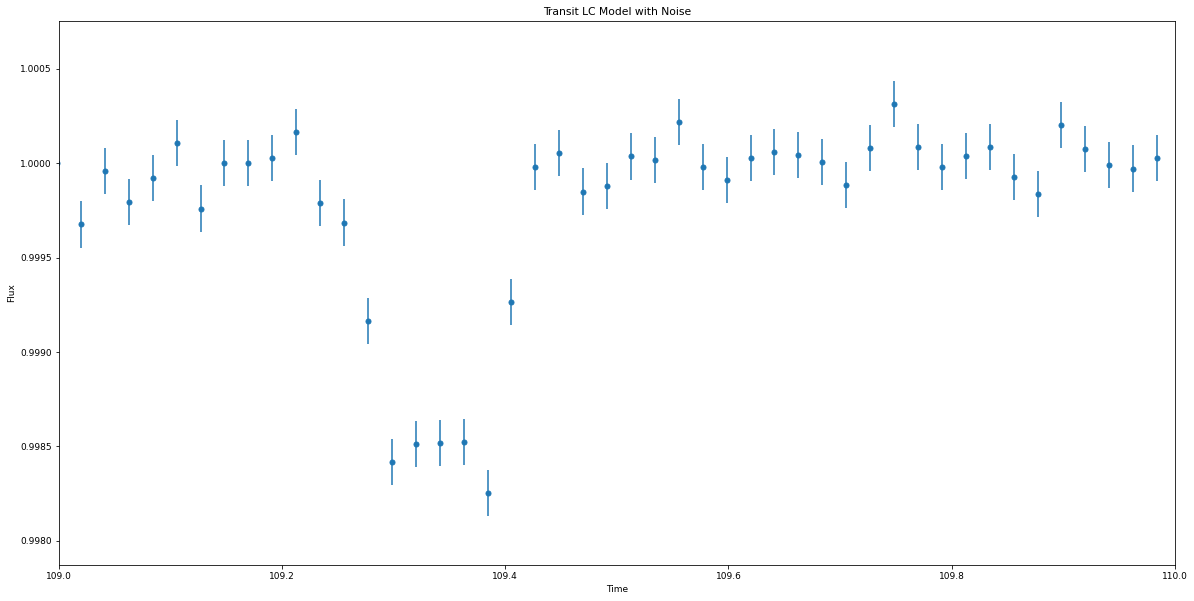

In [115]:
plt.errorbar(time-2454900, nflux, yerr=flux_err, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(109,110)
plt.title('Transit LC Model with Noise')

## Fitting the transit


`photoeccentric` includes functionality to fit using `juliet` with `multinest`.

First, I'll fit the transit shape with `juliet`. $Rp/Rs$, $a/Rs$, $i$, and $w$ are allowed to vary as free parameters. 

The transit fitter, `ph.planetlc_fitter`, fixes $e = 0.0$, even if the input eccentricity is not zero! This means that if e is not 0, the transit fitter will fit the "wrong" values for $a/Rs$ and $i$ -- but they will be wrong in such a way that reveals the eccentricity of the orbit. More on that in the next section.

I enter an initial guess based on what I estimate the fit parameters will be. For this one, I'll enter values close to the Kepler archive parameters.

##### Removing Out of Transit Data

In [116]:
koi.time = time
koi.flux = nflux
koi.flux_err = flux_err

Let's just do the first 7 transits.

In [117]:
koi.midpoints = koi.midpoints[0:7]

In [118]:
koi.remove_oot_data(7, 6)

Text(0.5, 1.0, 'Transit LC Model with Noise')

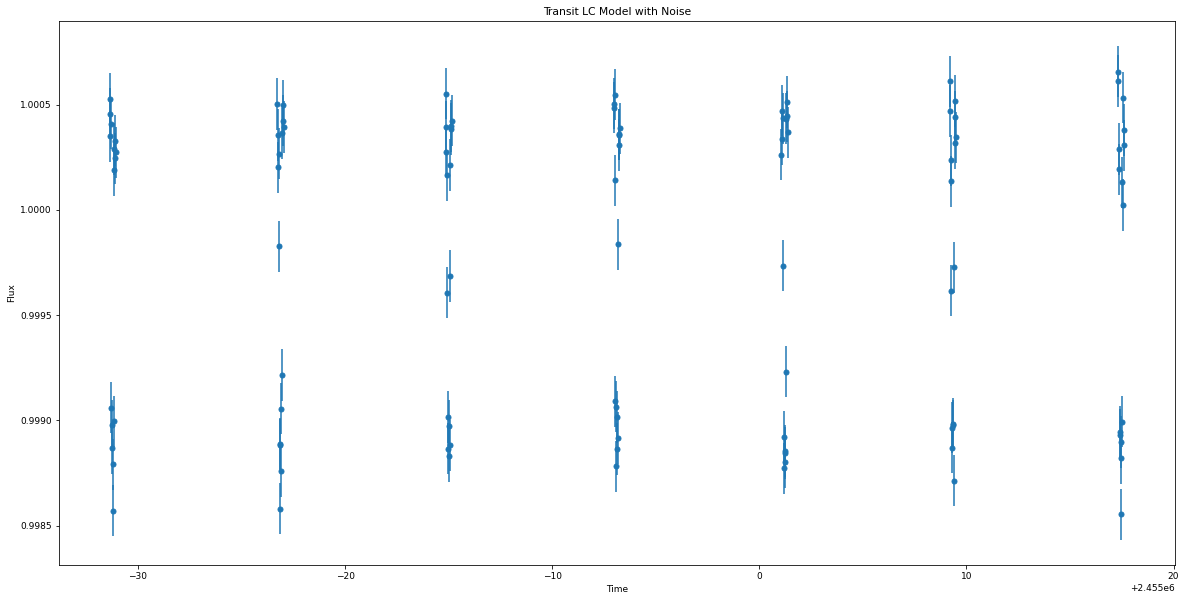

In [119]:
plt.errorbar(koi.time_intransit, koi.flux_intransit, yerr=koi.fluxerr_intransit, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Transit LC Model with Noise')

In [120]:
nlive=1000
nsupersample=29
exptimesupersample=0.0201389

In [121]:
dataset, results = koi.do_tfit_juliet(direct, nsupersample=nsupersample, exptimesupersample=exptimesupersample, nlive=nlive)

Fitting KOI 818.01
  analysing data from tutorial/818.01/e_0.3_w_270.0/jomnest_.txt


In [122]:
res = pd.read_table(direct + 'posteriors.dat')

In [123]:
# Print transit fit results from Juliet
res

,# Parameter Name,,Median,.1,Upper 68 CI,.2,Lower 68 CI
0,P_p1,,8.11420,,0.00026,,0.00025
1,t0_p1,,2455009.33950,,0.00073,,0.00075
2,p_p1,,0.03747,,0.00088,,0.00066
3,b_p1,,0.31019,,0.27339,,0.19107
4,q1_KEPLER,,0.22179,,0.19919,,0.11521
5,q2_KEPLER,,0.22274,,0.28201,,0.14961
6,a_p1,,17.96124,,0.81427,,2.54359
7,mflux_KEPLER,,-0.00038,,0.00001,,0.00001
8,sigma_w_KEPLER,,7.36109,,24.59268,,6.53386


In [124]:
# Save fit planet parameters to variables for convenience
per_f = res.iloc[0][2]
t0_f = res.iloc[1][2]
rprs_f = res.iloc[2][2]
b_f = res.iloc[3][2]
a_f = res.iloc[6][2]

i_f = np.arccos(b_f*(1./a_f))*(180./np.pi)


Below, I print the original parameters and fit parameters, and overlay the fit light curve on the input light curve. 

Because I input $e = 0.0$, the transit fitter should return the exact same parameters I input (because the transit fitter always requires $e = 0.0$).

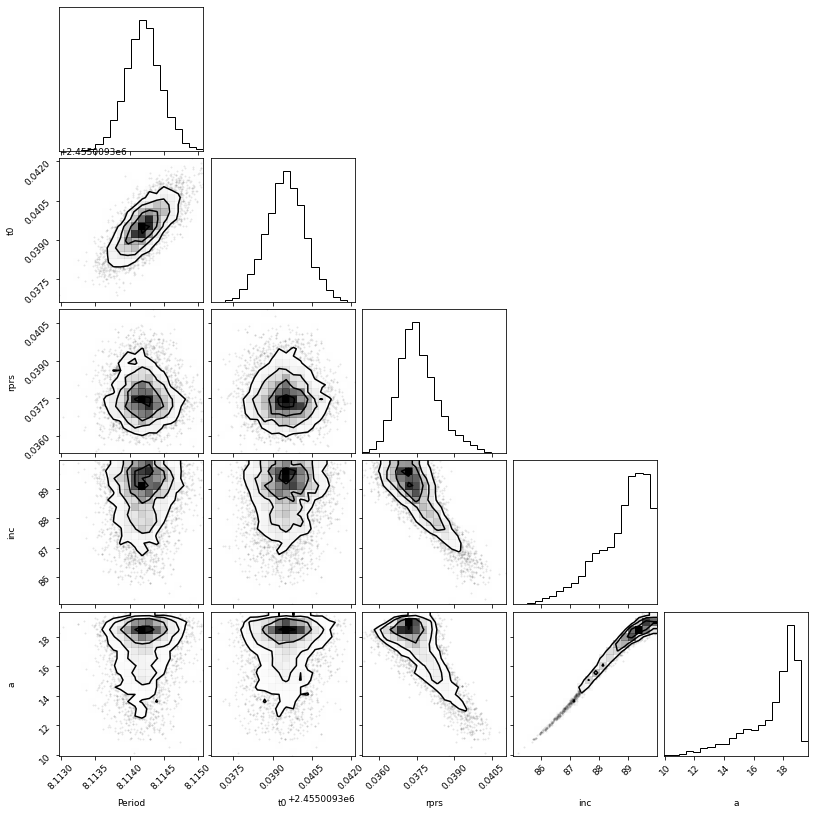

In [125]:
# Plot the transit fit corner plot
p = results.posteriors['posterior_samples']['P_p1']
t0 = results.posteriors['posterior_samples']['t0_p1']
rprs = results.posteriors['posterior_samples']['p_p1']
b = results.posteriors['posterior_samples']['b_p1']
a = results.posteriors['posterior_samples']['a_p1']
inc = np.arccos(b*(1./a))*(180./np.pi)

params = ['Period', 't0', 'rprs', 'inc', 'a']

fs = np.vstack((p, t0, rprs, inc, a))
fs = fs.T

figure = corner.corner(fs, labels=params)

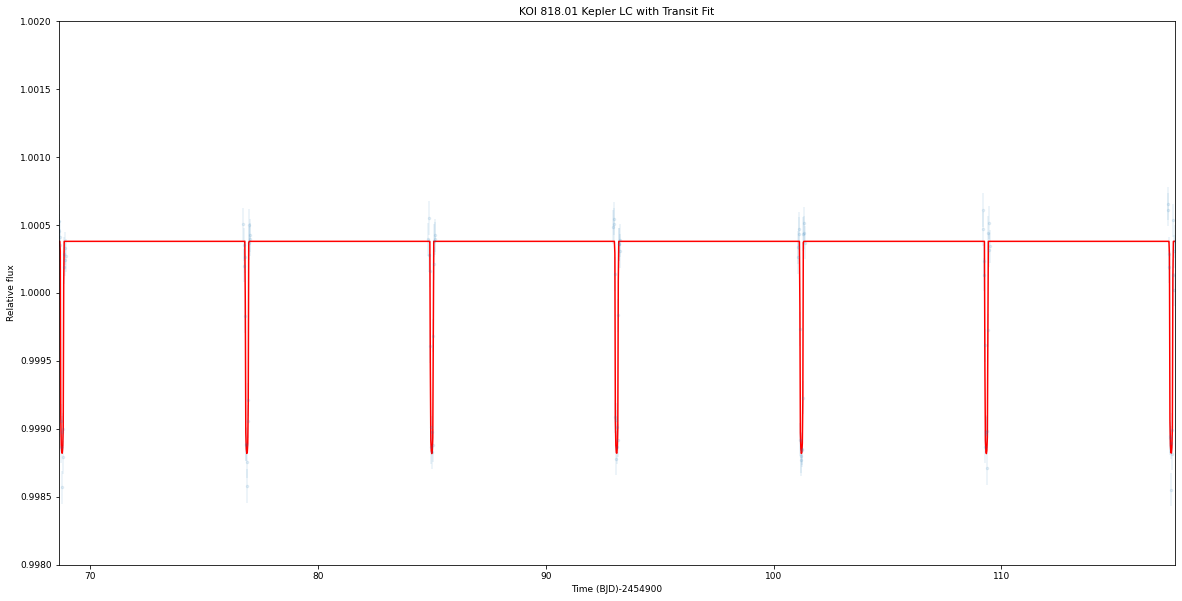

In [126]:
# Plot the data:
plt.errorbar(dataset.times_lc['KEPLER']-2454900, dataset.data_lc['KEPLER'], \
             yerr = dataset.errors_lc['KEPLER'], fmt = '.', alpha = 0.1)

# Plot the model:
plt.plot(dataset.times_lc['KEPLER']-2454900, results.lc.evaluate('KEPLER'), c='r')

# Plot portion of the lightcurve, axes, etc.:
plt.xlabel('Time (BJD)-2454900')
plt.xlim(np.min(dataset.times_lc['KEPLER'])-2454900, np.max(dataset.times_lc['KEPLER'])-2454900)
plt.ylim(0.998, 1.002)
plt.ylabel('Relative flux')
plt.title('KOI 818.01 Kepler LC with Transit Fit')
plt.show()

### Determining T14 and T23

A crucial step to determining the $(e, w)$ distribution from the transit is calculating the total and full transit durations. T14 is the total transit duration (the time between first and fourth contact). T23 is the full transit duration (i.e. the time during which the entire planet disk is in front of the star, the time between second and third contact.)


Here, I'm using equations 14 and 15 from [this textbook](https://sites.astro.caltech.edu/~lah/review/transits_occultations.winn.pdf). We calculate T14 and T23 assuming the orbit must be circular, and using the fit parameters assuming the orbit is circular. (If the orbit is not circular, T14 and T23 will not be correct -- but this is what we want, because they will differ from the true T14 and T23 in a way that reveals the eccentricity of the orbit.)

In [127]:
koi.calc_durations()

In [128]:
print('Total Transit Duration: ', np.mean(koi.T14_dist), koi.T14_errs)
print('Full Transit Duration: ', np.mean(koi.T23_dist), koi.T23_errs)

Total Transit Duration:  0.14275268099236152 (0.0023435199725622413, 0.0027213269315621846)
Full Transit Duration:  0.12984540536601274 (0.0028364474698461817, 0.0027470745004642694)


# Get $g$

Finally, we can use all the values above to determine $\rho_{circ}$. $\rho_{circ}$ is what we would calculate the stellar density to be if we knew that the orbit was definitely perfectly circular. We  will compare $\rho_{circ}$ to $\rho_{star}$ (the true, observed stellar density we calculated from spectroscopy/Gaia), and get $g(e, w)$:
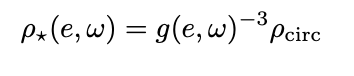

which is also defined as 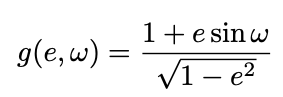

Thus, if the orbit is circular $(e = 0)$, then $g$ should equal 1. If the orbit is not circular $(e != 0)$, then $\rho_{circ}$ should differ from $\rho_{star}$, and $g$ should be something other than 1. We can draw a $(e, w)$ distribution based on the value we calcaulte for $g(e,w)$!

`ph.get_g_distribution()` will help us determine the value of g. This function takes the observed $\rho_{star}$ as well as the fit (circular) transit parameters and calculated transit durations, and calculates $\rho_{circ}$ and $g(e,w)$ based on equations 6 and 7 in [Dawson & Johnson 2012](https://arxiv.org/pdf/1203.5537.pdf).

Print $g$ and $\sigma_{g}$:

In [129]:
koi.get_gs()

In [130]:
g_mean = koi.g_mean
g_sigma = koi.g_sigma

In [131]:
g_mean

0.7068865305684935

In [132]:
g_sigma

0.05878274160478003

The mean of $g$ is about 1.0, which means that $\rho_{circ}$ agrees with $\rho_{star}$ and the eccentricity of this transit must be zero, which is exactly what we input! We can take $g$ and $\sigma_{g}$ and use MCMC (`emcee`) to determine the surface of most likely $(e,w)$.

`photoeccentric` has the probability function for $(e,w)$ from $g$ built in to `ph.log_probability()`.

In [ ]:
koi.do_eccfit(direct)

8270it [00:35, 494.12it/s, batch: 6 | bound: 29 | nc: 25 | ncall: 112747 | eff(%):  7.150 | loglstar: -0.864 <  2.758 <  2.767 | logz:  0.235 +/-  0.100 | stop:  1.863]          

In [ ]:
with open(direct + '/kepewdres.pickle', 'rb') as f:
    ewdres = pickle.load(f)

In [ ]:
labels = ["w", "e"]

fig = corner.corner(ewdres.samples, labels=labels, title_kwargs={"fontsize": 12}, truths=[w, e], plot_contours=True)

And here is the corner plot for the most likely values of $(e, w)$ that correspond to $g = 1$. The $e$ distribution peaks at 0!